In [53]:
import requests
import json

url = '10.168.20.20:5010'
entries = ['5b491e3dd7f17a0025e48d76']
rolesa = '5afdb8cf93beb10025c13f4f'

url = 'localhost:5010'
entries = ['5b3ec47706f9e50f2f36acc8', '5b3fd54906f9e50f2f36acc9']
rolesa = '593f49be42d3ed97390f25a7'

In [54]:
pipeline = [
    {'$match': {'_id': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {
                    'name': 1, 'family': 1, 
                    'deps._id': 1, 'deps.endpoint': 1, 
                    'nodes._id': 1, 'nodes.deps': 1, 'nodes.name': 1, 'nodes.family': 1, 'nodes.servers': 1
                 }
    }
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()

In [55]:
import sys
import os
import numpy as np
cwd = os.getcwd()
spltted = cwd.split('/')[:-1]
sys.path.append('/'.join(spltted))

import networkx as nx
from app.services.gridOrchestrator import GridOrchestrator
from app.libs.network.baseNetwork import BaseNetwork
from app.libs.histograms.histogram import Histogram
from app.libs.histograms.grid import GridHistogram

from svgwrite import Drawing

network = BaseNetwork()
network.make(data.get('items')).get_graph()

In [56]:
class DrawArea(object):
    def __init__(self, off, size, max_x, max_y):
        self._off = off
        self._size = size
        self._max_x = max_x
        self._max_y = max_y

    def area_x(self):
        size_x = (self._size[0] / 2)
        area_x = size_x * (self._max_x + self._max_y) * self._off[0]
        
        if self._off[0] > 1:
            area_x = area_x - (size_x / self._off[0])
        
        return area_x
    
    def area_y(self):
        size_y = (self._size[1] / 4)

        area_y = (size_y * (self._max_x + (self._max_y -1 )) * self._off[1]) + (self._size[1])
        return area_y
    
    def area(self):
        area_x = self.area_x()
        area_y = self.area_y()
        return (area_x, area_y)

    
class Symbol(object):
    
    def __init__(self, draw=Drawing):
        self.dwg = draw
        self._s_basket = {}
    
    def create_symbol(self, name, objs, viewbox):
        symbol = self.dwg.symbol(id=name)
        self.dwg.defs.add(symbol)
        
        symbol.viewbox(*viewbox)
        
        for obj in objs:
            symbol.add(obj)
        
        self._s_basket[name] = symbol
    
    def use_symbol(self, name, pos, opts={}):
        syb = self._s_basket[name]
        return self.dwg.use(syb, insert=pos, **opts)
    
    def square(self, pos, size, opts={}):
        return self.dwg.rect(insert=pos, size=size, **opts)
    
    def polyne(self, points, opt={}):
        return self.dwg.polyline(points=points, **opt)
    
    def text(self, title, pos, opt):
        return self.dwg.text(title, insert=pos, **opt)
    
class SymbolApps(Symbol):
    
    def app(self, pos, title, size):
        opts = {
            'size': size
        }

        return self.use_symbol('grid', (pos[0], pos[1]+32), opts)


In [57]:
class SymbolApplications(object):
    
    def create():
        pass

In [58]:
class MatrixRotation(object):
    
    def __init__(self, max_x, max_y, size, off):
        self._off = off
        self._size = size
        
        self._rect_y = (self._size[1] / 4) * max_x * self._off[1]

    def cal_offy(self, x, y, size):
        size_y = (self._size[1] * 0.5) / 2
        return self._rect_y - (size_y * x * self._off[0]) + (size_y * y * self._off[1])
    
    def cal_offx(self, x, y, size):
        size_x = self._size[0] / 2
        return (size_x * y * self._off[1]) + (size_x * x * self._off[0])
    
class DrawTemplateSVG(object):
    def __init__(self, max_x, max_y, darea=DrawArea, symbols=SymbolApps, matrix=MatrixRotation):
        self._off = (1.4, 1.4)
        self._size = (100, 120)

        self._matrix = matrix(max_x, max_y, self._size, self._off)
        self._area = darea(self._off, self._size, max_x, max_y).area()

        self.dwg = Drawing('test.svg', size=self._area)
        self._symbols = symbols(self.dwg)
        
        self.setup()
    
    def setup(self):
        symbol = self._symbols.square((0,0), size=self._area, opts={'fill': "#ededed"})
        self.add(symbol)
        
        obj = self._symbols.polyne([(133.2, 0),  (0, 78.16), (133.2, 156.32), (266.4, 78.16)], {'fill': "#a0501a"})
        self._symbols.create_symbol('grid', [obj], (0, 0, 266.4, 156.32))
    
    def draw_app(self, pos, name, size):
        pos = self.cal_off(pos, size)
        
        symbol = self._symbols.square(pos, self._size, {'fill': "rgb(255, 255, 0)", 'fill-opacity': '0.25'})
        self.add(symbol)
        
        symbol = self._symbols.app(pos, name, self._size)
        self.add(symbol)
        

    def cal_off(self, pos, size):
        x = self._matrix.cal_offx(*pos, size)
        y = self._matrix.cal_offy(*pos, size)
        
        return (x, y)

    def add(self, symbol):
        self.dwg.add(symbol)
        
    def save(self):
        self.dwg.save()
        return self.dwg.get_xml()


class DrawLayout(object):
    def __init__(self, grid, index, draw=DrawTemplateSVG):
        
        self._grid = grid
        self._index = index
        
        self._max_x = max(self._grid, key=int)
        self._max_y = max(self._grid[0], key=int)
        
        self.drawer = draw(self._max_x, self._max_y)

    def draw_nodes(self):
        
        for col_k in range(self._max_x, -1, -1):
            if col_k in self._grid:
                columm = self._grid[col_k]
                max_y = max(self._grid[col_k], key=int)
            
                for line_k in range(0, max_y):
                    if line_k in self._grid[col_k]:
                        
                        label = self._grid[col_k][line_k]
                    
                        if label in self._index:
                            item = self._index[label]
                            name = item[3].get('name', '-')
                            size = item[2]
                        else:
                            name = '-'
                            size = 1

                        name = "%s / %s -- %s" % (col_k, line_k, size)
                        self.drawer.draw_app((col_k, line_k), name, size)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            size = []
            
            for i in range(2):
                ipos = self._index[edge[i]]
                pos.append(ipos)
                w.append(ipos[0])
                size.append(ipos[2])

            #self.drawer.draw_connect(*pos, *w, *size)
            
        return self
    
    def save(self):
        return self.drawer.save()

-------------------------


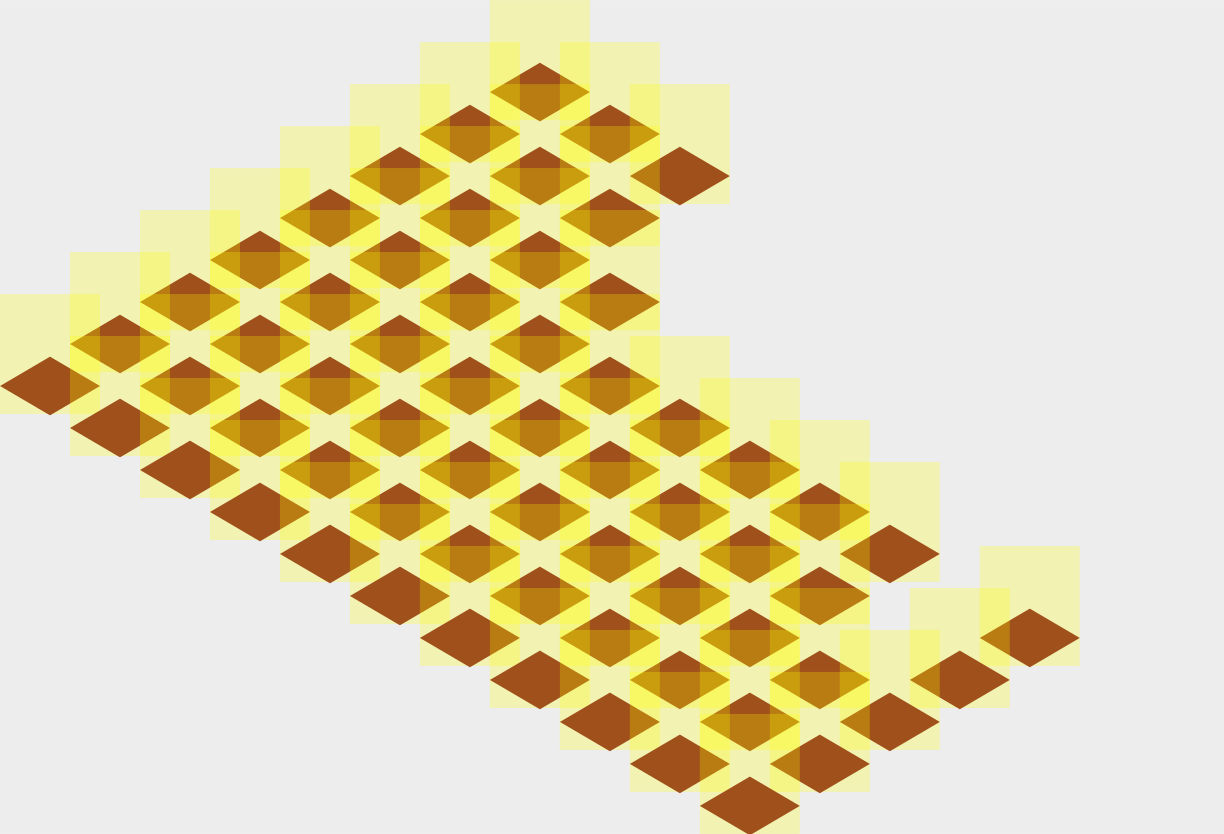

In [59]:
from IPython.display import SVG, display

print("-------------------------")
Orchestration = GridOrchestrator(network.graph)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid().get_grid(), Orchestration.get_grid().get_index())
Layout.draw_nodes()
Layout.draw_connections(network.graph.edges(data='endpoint'))
Layout.save()
   
display(SVG(filename='test.svg'))